In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from source.base import log_prob, log_prob_unnormalized
from scipy import linalg
import matplotlib as mpl
from source.plot_func import get_ecp, plt_potential_func
from scipy.linalg import sqrtm



torch.manual_seed(123)
np.random.seed(123)

 
mu_p = torch.tensor([0.0, 0.0])
scale_p = torch.tensor([[0.8, 0.4],
                        [0.4, 0.8]])

cov_p = scale_p @ scale_p.T
#s_p = sqrtm(cov_p)
#scale_p = torch.tensor(s_p)

mu_q = torch.tensor([4.0, 2.0])
scale_q = torch.tensor([[0.8, 0.0000],
                        [0.0, 0.8]])
p = [mu_p, scale_p]
q = [mu_q, scale_q]

def eva_kl(mu_q, scale_q, gaussian=True):
    
    z = torch.randn([100, 2])
    x = mu_q + z @ scale_q.T
    if gaussian:
         log_ratio = log_prob_unnormalized(mu_p, scale_p, x) - log_prob(mu_q, scale_q, x)
    return -log_ratio.mean(0)

def wasserstein2(mu1, cov1):
    mu1 = mu1
    mu2 = mu_p

    cov1 = cov1
    cov2 = cov_p
    
    s1 = sqrtm(cov1.numpy())
    s1cov2s1 = s1 @  cov2.numpy() @ s1
    d2 = torch.norm(mu1 - mu2)**2 + torch.trace(cov1 + cov2- 2 * sqrtm(s1cov2s1))
    return torch.sqrt(d2)

In [2]:
def grad_logp(x, logp):
    return torch.autograd.grad(logp(x), x, grad_outputs=torch.ones_like(logp(x)), 
                               create_graph=False)[0]
    

p_true = torch.distributions.multivariate_normal.MultivariateNormal(mu_p, cov_p)
p_0 = torch.distributions.multivariate_normal.MultivariateNormal(mu_q, scale_q@scale_q.T)
x_0 = p_0.sample([300])


x_t = [x_0.detach()]

x_0.requires_grad=True

for i in range(1001):
    x_0 = x_0 + 0.01*grad_logp(x_0, p_true.log_prob) + np.sqrt(0.01*2) * torch.randn_like(x_0)
    x_t.append(x_0.detach())
    
    
mu_t = torch.stack([torch.mean(x_t[i], axis=0) for i in range(len(x_t))])
cov_t = np.stack([np.cov(x_t[i].T) for i in range(len(x_t))])

#### BBVI using path-derivative (stl) and reparameterization gradients

In [3]:
def train(q, p, detach=False, number_iter=1000, lr=0.001):
    
    mu_p, scale_p = p
    mu_q, scale_q = q[0].clone(), q[1].clone()
    
    mu_q.requires_grad = True
    scale_q.requires_grad = True
    opt = torch.optim.SGD([mu_q, scale_q], lr=lr)
    
    mus = np.zeros([number_iter, 2])
    scales = np.zeros([number_iter, 2, 2])
    kl = []
    for i in range(number_iter):
        mus[i] = mu_q.detach()
        scales[i] = scale_q.detach()
        #kl.append(eva_kl(mu_q.detach(), scale_q.detach()))
        kl.append(wasserstein2(mu_q.detach(), scale_q.detach() @ scale_q.detach().T))
        
        opt.zero_grad()
        
        z = torch.randn([5, 2])
        
        # reparameterization trick
        x = mu_q + z @ scale_q.T
        if not detach:
            log_ratio = log_prob_unnormalized(mu_p, scale_p, x) - log_prob(mu_q, scale_q, x)
        else:
            log_ratio = log_prob_unnormalized(mu_p, scale_p, x) - log_prob(mu_q.detach(), scale_q.detach(), x)
            number_iter
        loss = torch.mean(-log_ratio)  
        loss.backward()
        opt.step()

    return mus, scales, kl

### The forward Euler scheme to the ODE system by Lambert et.al.

In [4]:
def grad_logp(x, f):
    return torch.autograd.grad(f, x, grad_outputs=torch.ones_like(f), 
                               create_graph=False)[0]

def compute_cov_grad(grad_logr, m):

    batch_matrix1 = grad_logr[:, np.newaxis, :]
    batch_matrix2 = m[:, np.newaxis, :]
    s = torch.bmm(batch_matrix1.permute(0, 2, 1), batch_matrix2)+\
                torch.bmm(batch_matrix2.permute(0, 2, 1), batch_matrix1)
    return s

def train_ode_cov(q, p, number_iter=1000, lr=0.01, if_rosen=False):
    mu_p, scale_p = p
    mu_q, scale_q = q[0].clone(), q[1].clone()
    
    cov_q = (scale_q @ scale_q.T)
    mus = np.zeros([number_iter, 2])
    covs = np.zeros([number_iter, 2, 2])
    kl = []
    for i in range(number_iter):
        mus[i] = mu_q.detach().numpy()
        covs[i] = cov_q.detach().numpy()
        
        q_dist = torch.distributions.multivariate_normal.MultivariateNormal(mu_q, cov_q)
        x = q_dist.sample([5])
      
        x.requires_grad = True
    
        kl.append(wasserstein2(mu_q, cov_q))
        if if_rosen:
            log_p = - p_rosen_dist.nl_pdf(x)
        else:
            log_p = log_prob_unnormalized(mu_p, scale_p, x)
    
        log_ratio = log_p - q_dist.log_prob(x)
        grad_logr = grad_logp(x, log_ratio)
        mu_q = mu_q + lr*grad_logr.mean(0)
        mu_q = mu_q.detach()
        x = x.detach().clone()
        grad_cov = compute_cov_grad(grad_logr, x-mu_q)
        cov_q = cov_q + lr*grad_cov.mean(0)
        cov_q = cov_q.detach()
        
    return mus, covs, kl


In [5]:
mus_rep, scales_rep, kl_rep = train(q, p, detach=False, number_iter=1001, lr=0.01)
mus_path, scales_path, kl_path = train(q, p, detach=True, number_iter=1001, lr=0.01)
mus_ode, covs_ode, kl_ode = train_ode_cov(q, p, number_iter=1001, lr=0.01)   


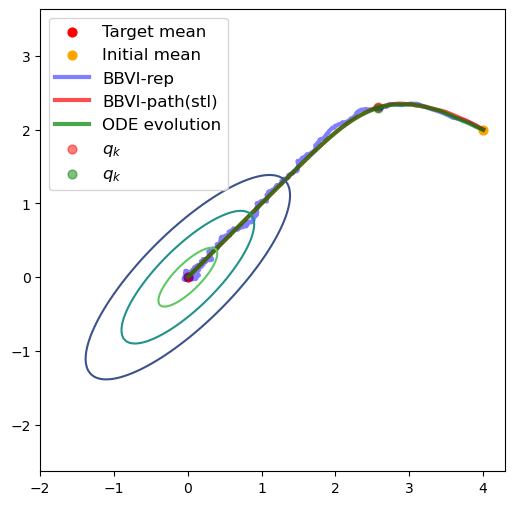

In [6]:
plt.figure(figsize=(6,6))
    #plt.tick_params(left = False, right = False , labelleft = False ,
                #labelbottom = False, bottom = False)
plt.scatter(x=mu_p[0], y=mu_p[1], s=40, label='Target mean', alpha=1.0, color='red', zorder=0)
plt.scatter(x=mus_path[0][0], y=mus_path[0][1], s=40, label='Initial mean', alpha=1.0, color='orange', zorder=0)
plt.plot(mus_rep[:, 0], mus_rep[:, 1], linestyle = '-', label='BBVI-rep', alpha=0.5,color='blue', linewidth=3)
plt.plot(mus_path[:, 0], mus_path[:, 1], linestyle = '-', label='BBVI-path(stl)', alpha=0.7, color='red', linewidth=3, zorder=2)
plt.plot(mus_ode[:, 0], mus_ode[:, 1], linestyle = '-', label='ODE evolution', alpha=0.7, color='green', linewidth=3)
    
plt.scatter(x=mus_path[30][0], y=mus_path[30][1], s=40, label=r'$q_k$' ,alpha=0.5, color='red')
plt.scatter(x=mus_ode[30][0], y=mus_ode[30][1], s=40, label=r'$q_k$', alpha=0.5, color='green')
plt.axis('equal')
plt.legend(prop={'size': 12}, loc='upper left')

xlim=[-2, 2] 
ylim=[-2, 2]
num_grid=100

#mu = torch.Tensor([1.0])
#a = torch.Tensor([1.0])
#b = torch.ones([2, 1])

p_dist = torch.distributions.multivariate_normal.MultivariateNormal(mu_p, cov_p)

xlist = np.linspace(xlim[0], xlim[1], num_grid)
ylist = np.linspace(ylim[0], ylim[1], num_grid)
X, Y = np.meshgrid(xlist, ylist)
XY = np.stack([X.reshape(-1), Y.reshape(-1)], axis=1).astype("float32")
Z = (p_dist.log_prob(torch.tensor(XY))).exp().reshape([100, 100])
#plt.tick_params(left = False, right = False , labelleft = False ,
                #labelbottom = False, bottom = False)
plt.ylim(-2, 3)
plt.contour(X, Y, Z, levels=3, cmap='viridis')


plt.show()

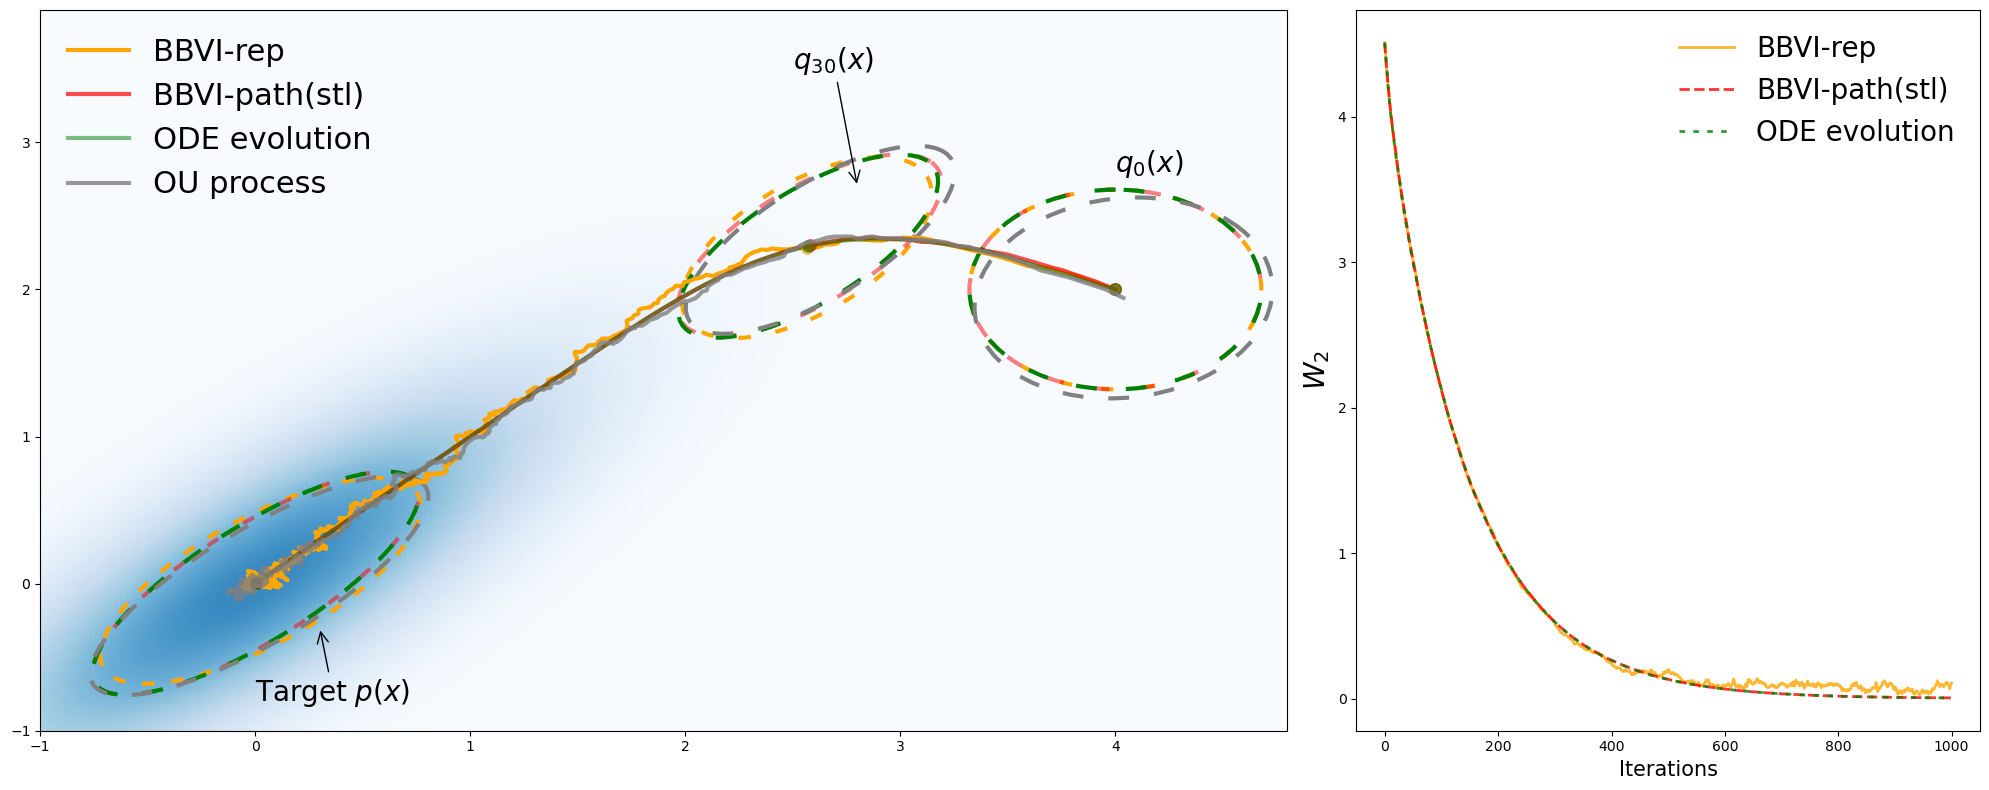

In [9]:

s_ecp = 1.2
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1.5]}, figsize=(20, 8))
#figax1 = plt.subplots(figsize=(10, 5))

def log_p(x):
    return log_prob_unnormalized(mu_p, scale_p, x)


plt_potential_func(log_p, ax1, cmap='Blues')

ax1.text(4, 2.8, r'$q_{0}(x)$', size=20)
ax1.annotate(r'Target $p(x)$', xy=(0.3, -0.3), xytext=(0.0, -0.8),size=20,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
ax1.annotate(r'$q_{30}(x)$', xy=(2.8, 2.7), xytext=(2.5, 3.5), size=20,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

ax1.plot(mus_rep[:, 0], mus_rep[:, 1], linestyle = '-', label='BBVI-rep', alpha=1.0,color='orange', linewidth=3)
ax1.plot(mus_path[:, 0], mus_path[:, 1], linestyle = '-', label='BBVI-path(stl)', alpha=0.7, color='red', linewidth=3)
ax1.plot(mus_ode[:, 0], mus_ode[:, 1], linestyle = '-', label='ODE evolution', alpha=0.5, color='green', linewidth=3)

#plt.scatter(x=mu_p[0], y=mu_p[1], s=40, label='Target mean', alpha=1.0, color='red', zorder=2)
#plt.scatter(x=mus_path[0][0], y=mus_path[0][1], s=40, label='Initial mean', alpha=1.0, color='orange', zorder=2)




ax1.scatter(x=mus_rep[0][0], y=mus_rep[0][1], s=70, alpha=0.5, color='orange', zorder=2)
get_ecp(mus_rep[0], scales_rep[0]@scales_rep[0].T, ax1, s=s_ecp, color='orange', style= (0, (3, 7)), alpha=1.0)
ax1.scatter(x=mus_path[0][0], y=mus_path[0][1], s=70, alpha=0.5, color='red', zorder=2)
get_ecp(mus_path[0], scales_path[0]@scales_path[0].T, ax1, s=s_ecp, color='red', style=(0, (4, 7)), alpha=0.5)
ax1.scatter(x=mus_ode[0][0], y=mus_ode[0][1], s=70, alpha=0.5, color='green', zorder=2)
get_ecp(mus_ode[0], covs_ode[0], ax1, s=s_ecp, color='green', style=(0, (5, 7)))


step = 30
ax1.scatter(x=mus_rep[step][0], y=mus_rep[step][1], s=70, alpha=0.5, color='orange', zorder=2)
get_ecp(mus_rep[step], scales_rep[step]@scales_rep[step].T, ax1, s=s_ecp, color='orange', style= (0, (3, 6)), alpha=1.0)
ax1.scatter(x=mus_path[step][0], y=mus_path[step][1], s=70, alpha=0.5, color='red', zorder=2)
get_ecp(mus_path[step], scales_path[step]@scales_path[step].T, ax1, s=s_ecp, color='red', style=(0, (4, 6)), alpha=0.5)
ax1.scatter(x=mus_ode[step][0], y=mus_ode[step][1], s=70, alpha=0.5, color='green', zorder=2)
get_ecp(mus_ode[step], covs_ode[step], ax1, s=s_ecp, color='green',  style= (0, (5, 6)))



ax1.scatter(x=mus_rep[-1][0], y=mus_rep[-1][1], s=70, alpha=0.5, color='orange', zorder=2)
get_ecp(mus_rep[-1], scales_rep[-1]@scales_rep[-1].T, ax1, s=s_ecp, color='orange', style= (0, (3, 4)), alpha=1.0)
ax1.scatter(x=mus_path[-1][0], y=mus_path[-1][1], s=70, alpha=0.5, color='red', zorder=2)
get_ecp(mus_path[-1], scales_path[-1]@scales_path[-1].T, ax1, s=s_ecp, color='red', style=(0, (3, 7)), alpha=0.5)
ax1.scatter(x=mus_ode[-1][0], y=mus_ode[-1][1], s=70, alpha=0.5, color='green', zorder=2)
get_ecp(mus_ode[-1], covs_ode[-1],ax1, s=s_ecp, color='green', style= (0, (5, 6)))

ax1.plot(mu_t[:, 0], mu_t[:, 1], linestyle = '-', label='OU process', alpha=0.8,color='grey', linewidth=3)
get_ecp(mu_t[0], cov_t[0] ,ax1, s=s_ecp, color='grey', style= (0, (5, 6)))
get_ecp(mu_t[30], cov_t[30] ,ax1, s=s_ecp, color='grey', style= (0, (5, 6)))
get_ecp(mu_t[-1], cov_t[-1] ,ax1, s=s_ecp, color='grey', style= (0, (5, 6)))

ax1.legend(prop={'size': 22}, loc='upper left', frameon=False)

ax1.set_ylim(-1.0, 3.9)
ax1.set_xlim(-1.0, 4.8)

ax2.plot(kl_rep,'-', label='BBVI-rep', color='orange', alpha=0.8, linewidth=2)
ax2.plot(kl_path,  '--',label='BBVI-path(stl)', color='red', alpha=0.8, linewidth=2)
ax2.plot(kl_ode, linestyle=(0, (2, 3)),label='ODE evolution', color='green', alpha=0.8, linewidth=2)
ax2.legend(prop={'size': 20}, loc='upper right', frameon=False)
ax2.set_xlabel('Iterations', size=15)
ax2.set_ylabel(r'$W_2$', size=20)
fig.tight_layout()

In [8]:
#mus_rep, scales_rep = train(q, p, detach=False, number_iter=301, lr=0.001)
#mus_path, scales_path = train(q, p, detach=True, number_iter=301, lr=0.001)
#mus_ode, covs_ode = train_ode_cov(q, p, number_iter=301, lr=0.001)   